<a href="https://colab.research.google.com/github/Koanah/CNNs_rediscovered-/blob/main/Resnet50_stage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install SimpleITK --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 47.6 MB/s eta 0:00:00


In [2]:
import os, numpy as np, pandas as pd, tensorflow as tf, SimpleITK as sitk, cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:

# Load scans, candidates, and build cropped dataset

from google.colab import drive
drive.mount("/content/drive")

BASE_PATH = "/content/drive/MyDrive/LUNA16_trial"
CAND_PATH = os.path.join(BASE_PATH, "candidate_boxes.csv")
ANN_PATH  = os.path.join(BASE_PATH, "annotations.csv")

candidates = pd.read_csv(CAND_PATH)
annotations = pd.read_csv(ANN_PATH)
print(f" Loaded {len(candidates)} candidates and {len(annotations)} annotations.")

Mounted at /content/drive
 Loaded 7910 candidates and 1186 annotations.


In [4]:
# Helper functions

# load scans
def load_luna_scans(base_path):
    """
    Load all LUNA16 scans safely.
    Returns a dictionary: {scan_id: SimpleITK image}
    Skips missing or corrupt scans silently.
    """
    scans, skipped = {}, []
    for i in range(10):
        subset_path = os.path.join(base_path, f"subset{i}")
        if not os.path.exists(subset_path): continue
        for file in os.listdir(subset_path):
            if file.endswith(".mhd"):
                mhd_path = os.path.join(subset_path, file)
                raw_path = mhd_path.replace(".mhd", ".raw")
                if not os.path.exists(raw_path):
                    skipped.append(file)
                    continue
                try:
                    scan = sitk.ReadImage(mhd_path)
                    uid = file.replace(".mhd","")
                    scans[uid] = scan
                except Exception as e:
                    skipped.append(file)
    print(f" Loaded {len(scans)} scans successfully |  Skipped {len(skipped)} corrupt/missing")
    return scans

#nrmalize scans

def hu_to_float01(img, hu_min=-1000, hu_max=400):
    img = np.clip(img, hu_min, hu_max).astype(np.float32)
    return (img - hu_min) / (hu_max - hu_min + 1e-6)

def world_to_voxel(scan, coord):
    """Convert world (x,y,z) to voxel (i,j,k) index."""
    origin = np.array(scan.GetOrigin())
    spacing = np.array(scan.GetSpacing())
    direction = np.array(scan.GetDirection()).reshape(3,3)
    return np.linalg.inv(direction) @ ((np.array(coord) - origin) / spacing)

def crop_patch(scan, z_idx, x1, y1, x2, y2, target_size=224):
    arr = sitk.GetArrayFromImage(scan)
    z = int(np.clip(z_idx, 0, arr.shape[0]-1))
    img = hu_to_float01(arr[z])
    patch = img[int(y1):int(y2), int(x1):int(x2)]
    if patch.size == 0:
        return None
    patch_resized = tf.image.resize(patch[..., np.newaxis], (target_size, target_size)).numpy()
    patch_rgb = np.repeat(patch_resized, 3, axis=-1)
    return patch_rgb


# IoU helper for labeling true nodules vs false positives
def iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    union = max(0, (boxA[2]-boxA[0])) * max(0, (boxA[3]-boxA[1])) + \
            max(0, (boxB[2]-boxB[0])) * max(0, (boxB[3]-boxB[1])) - inter
    return inter / (union + 1e-6)



# On-demand scan loader (load one .mhd when needed)

def load_single_scan(seriesuid, base_path=BASE_PATH):
    """Find and load one scan by UID from any subset."""
    for i in range(10):
        subset_path = os.path.join(base_path, f"subset{i}")
        mhd_path = os.path.join(subset_path, f"{seriesuid}.mhd")
        raw_path = mhd_path.replace(".mhd", ".raw")
        if os.path.exists(mhd_path) and os.path.exists(raw_path):
            try:
                return sitk.ReadImage(mhd_path)
            except Exception as e:
                print(f" Could not load {seriesuid} in subset{i}: {e}")
                return None
    return None  # not found

In [5]:
print(" Filtering scans relevant to candidate boxes...")
needed_uids = set(candidates["seriesuid"].unique())
all_scans = load_luna_scans(BASE_PATH)
scans = {uid: scan for uid, scan in all_scans.items() if uid in needed_uids}
print(f" Kept {len(scans)} scans that correspond to candidate boxes.")

# Save filtered scans dictionary for reuse
np.save(os.path.join(BASE_PATH, "filtered_scan_ids.npy"), np.array(list(scans.keys())))

 Filtering scans relevant to candidate boxes...
 Loaded 708 scans successfully |  Skipped 178 corrupt/missing
 Kept 475 scans that correspond to candidate boxes.


# STEP 3: Build Dataset (auto-label patches)

In [9]:
def world_to_voxel(scan, coord):
    origin = np.array(scan.GetOrigin())
    spacing = np.array(scan.GetSpacing())
    direction = np.array(scan.GetDirection()).reshape(3,3)
    return np.linalg.inv(direction) @ ((np.array(coord) - origin) / spacing)

patches, labels = [], []

for idx, row in candidates.iterrows():
    seriesuid = row['seriesuid']
    x1, y1, x2, y2, z_idx = row['x1'], row['y1'], row['x2'], row['y2'], row['z_index']
    scan = scans.get(seriesuid, None)
    if scan is None:
        continue

    patch = crop_patch(scan, z_idx, x1, y1, x2, y2)
    if patch is None:
        continue

    # Ground truth conversion: world → voxel coordinates
    ann = annotations[annotations['seriesuid'] == seriesuid]
    label = 0
    for _, gt in ann.iterrows():
        gt_vox = world_to_voxel(scan, [gt['coordX'], gt['coordY'], gt['coordZ']])
        gt_x, gt_y, gt_z = gt_vox
        gt_box = [
            gt_x - gt['diameter_mm'] / (2 * scan.GetSpacing()[0]),
            gt_y - gt['diameter_mm'] / (2 * scan.GetSpacing()[1]),
            gt_x + gt['diameter_mm'] / (2 * scan.GetSpacing()[0]),
            gt_y + gt['diameter_mm'] / (2 * scan.GetSpacing()[1])
        ]

        # match z within tolerance (1 slice)
        if abs(z_idx - gt_z) <= 1 and iou([x1, y1, x2, y2], gt_box) >= 0.1:
            label = 1
            break

    patches.append(patch)
    labels.append(label)

    if (idx + 1) % 200 == 0:
        print(f"Processed {idx+1}/{len(candidates)} candidates")

X = np.array(patches, dtype=np.float32)
y = np.array(labels, dtype=np.int32)
print(f" Final dataset shape: {X.shape}, Positives: {np.sum(y)}, Negatives: {len(y) - np.sum(y)}")

# Save for reuse
np.save(os.path.join(BASE_PATH, "stage2_X.npy"), X)
np.save(os.path.join(BASE_PATH, "stage2_y.npy"), y)


Processed 200/7910 candidates
Processed 400/7910 candidates
Processed 600/7910 candidates
Processed 800/7910 candidates
Processed 1000/7910 candidates
Processed 1200/7910 candidates
Processed 1400/7910 candidates
Processed 1600/7910 candidates
Processed 1800/7910 candidates
Processed 2000/7910 candidates
Processed 2200/7910 candidates
Processed 2400/7910 candidates
Processed 2600/7910 candidates
Processed 2800/7910 candidates
Processed 3000/7910 candidates
Processed 3200/7910 candidates
Processed 3400/7910 candidates
Processed 3600/7910 candidates
Processed 3800/7910 candidates
Processed 4000/7910 candidates
Processed 4200/7910 candidates
Processed 4400/7910 candidates
Processed 4600/7910 candidates
Processed 4800/7910 candidates
Processed 5000/7910 candidates
Processed 5200/7910 candidates
Processed 5400/7910 candidates
Processed 5600/7910 candidates
Processed 5800/7910 candidates
Processed 6000/7910 candidates
Processed 6200/7910 candidates
Processed 6400/7910 candidates
Processed 66

In [23]:

''' STEP 3.5: Handle class imbalance with computed class weights

from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
#class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
#class_weights = dict(zip(classes, class_weights))
class_weights = {0: 1.0, 1: 4.0}

print("Computed class weights:", class_weights)'''


Computed class weights: {0: 1.0, 1: 4.0}


In [43]:
# ============================================================
# STEP 3.5: Oversample positive class for balance
# ============================================================
from sklearn.utils import resample

X_pos = X[y == 1]
X_neg = X[y == 0]
n_pos, n_neg = len(X_pos), len(X_neg)
print(f"Before oversampling -> Pos: {n_pos}, Neg: {n_neg}")

# Oversample positives to match negatives
X_pos_oversampled, y_pos_oversampled = resample(
    X_pos, np.ones(n_pos, dtype=np.int32),
    replace=True, n_samples=n_neg, random_state=42
)

X_bal = np.concatenate([X_neg, X_pos_oversampled], axis=0)
y_bal = np.concatenate([np.zeros(n_neg, dtype=np.int32), y_pos_oversampled], axis=0)
print(f"After oversampling -> Pos: {np.sum(y_bal)}, Neg: {len(y_bal) - np.sum(y_bal)}")

# Shuffle dataset
idx = np.arange(len(X_bal))
np.random.shuffle(idx)
X_bal, y_bal = X_bal[idx], y_bal[idx]

Before oversampling -> Pos: 731, Neg: 7179
After oversampling -> Pos: 7179, Neg: 7179


# Train/Validation Split + Augmentation

In [44]:
X_train, X_val, y_train, y_val = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


Train: (11486, 224, 224, 3), Val: (2872, 224, 224, 3)


# Build & Train ResNet50 Classifier

In [45]:
from tensorflow.keras import regularizers

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid",
               kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)


model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"])

callbacks = [
    ModelCheckpoint("best_resnet50_stage2.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=4),
    validation_data=(X_val, y_val),
    epochs=15,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2872/2872 ━━━━━━━━━━━━━━━━━━━━ 211s 53ms/step - accuracy: 0.6651 - loss: 0.6335 - val_accuracy: 0.6636 - val_loss: 1.8659
Epoch 2/15
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 120s 42ms/step - accuracy: 0.7382 - loss: 0.5151 - val_accuracy: 0.7653 - val_loss: 0.4720
Epoch 3/15
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 117s 41ms/step - accuracy: 0.7741 - loss: 0.4713 - val_accuracy: 0.7277 - val_loss: 0.5414
Epoch 4/15
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 120s 42ms/step - accuracy: 0.7980 - loss: 0.4308 - val_accuracy: 0.7859 - val_loss: 0.4534
Epoch 5/15
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 119s 41ms/step - accuracy: 0.8055 - loss: 0.4053 - val_accuracy: 0.8207 - val_loss: 0.3808
Epoch 6/15
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 117s 41ms/step - accuracy: 0.8316 - loss: 0.3825 - val_accuracy: 0.8019 - val_loss: 0.4158
Epoch 7/15
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 119s 41ms/step - accuracy: 0.8345 - loss: 0.3684 - val_accuracy: 0.8364 - val_loss: 0.3661
Epoch 8/15
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 119s 42ms/step - accuracy: 0.8482 - lo

#eVALUATION

In [46]:

val_loss, val_acc = model.evaluate(X_val, y_val)
y_pred = (model.predict(X_val) > 0.5).astype(int)

print(f"\n Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred):.4f}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8994 - loss: 0.2742
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step

 Validation Accuracy: 0.9049, Loss: 0.2466
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1436
           1       0.87      0.95      0.91      1436

    accuracy                           0.90      2872
   macro avg       0.91      0.90      0.90      2872
weighted avg       0.91      0.90      0.90      2872

Confusion Matrix:
[[1232  204]
 [  69 1367]]
ROC-AUC: 0.9049


In [47]:
import matplotlib.pyplot as plt

# Plot training curves

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8994 - loss: 0.2742
 Validation Accuracy: 0.9049, Loss: 0.2466


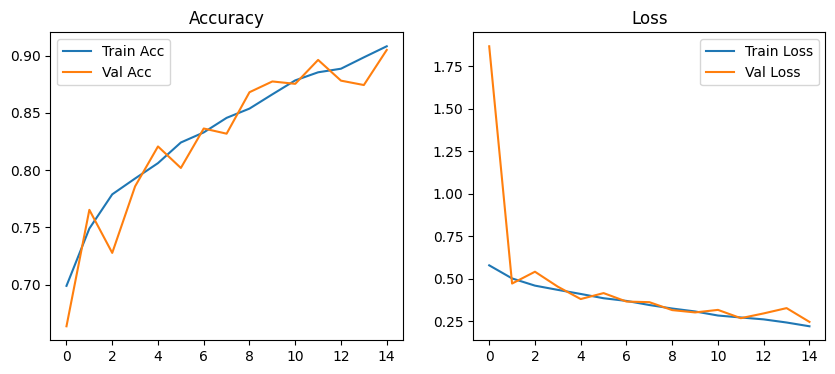

In [48]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f" Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()